# 發票與收據 OCR 辨識測試

本 notebook 測試多種 OCR 方案來辨識繁體中文發票和收據,從簡單到進階排序。

## 目錄

### 🚀 基礎 OCR 方案
1. **EasyOCR (基礎版)** - 最簡單,只輸出文字
2. **EasyOCR (詳細版)** - 含座標和信心度
3. **EasyOCR + 視覺化** - 在圖片上標記文字區域

### 🔧 圖片預處理方案
4. **Deskew** - 自動矯正傾斜角度
5. **Imutils 文件掃描** - 模擬掃描儀效果
6. **OpenCV 自動裁切** - 邊緣偵測與透視變換

### ⭐ 進階 OCR 方案
7. **DocTR** - 專業文檔 OCR 解決方案
8. **PaddleOCR** - 百度開源 OCR (簡體中文為主)

---

Loading DocTR model...


65815552it [00:01, 39806786.77it/s]                              


63303680it [03:20, 316296.48it/s]                               


Loading document...
Running OCR...

DocTR OCR Results:
  Word: 'LE' (confidence: 0.919)
 1. LE
  Word: 'Tel:2495-0822' (confidence: 0.509)
 2. Tel:2495-0822
  Word: '#:' (confidence: 0.957)
  Word: '1' (confidence: 1.000)
 3. #: 1
  Word: 'Tbl' (confidence: 1.000)
  Word: 'No.:' (confidence: 0.991)
  Word: '5' (confidence: 1.000)
 4. Tbl No.: 5
  Word: 'Cardno:' (confidence: 0.972)
  Word: '800012' (confidence: 1.000)
 5. Cardno: 800012
  Word: 'Staff:' (confidence: 0.987)
  Word: '&K' (confidence: 0.346)
  Word: 'ML' (confidence: 0.368)
  Word: 'B' (confidence: 0.819)
 6. Staff: &K ML B
  Word: 'Guest' (confidence: 0.997)
  Word: 'No.:' (confidence: 0.997)
  Word: '2' (confidence: 1.000)
 7. Guest No.: 2
  Word: 'Date:' (confidence: 0.998)
  Word: '2025-09-26' (confidence: 0.888)
 8. Date: 2025-09-26
  Word: 'Time:' (confidence: 0.999)
  Word: '18:38' (confidence: 0.979)
 9. Time: 18:38
  Word: '17:50' (confidence: 0.994)
  Word: 'C014717' (confidence: 0.354)
10. 17:50 C014717
  Word:

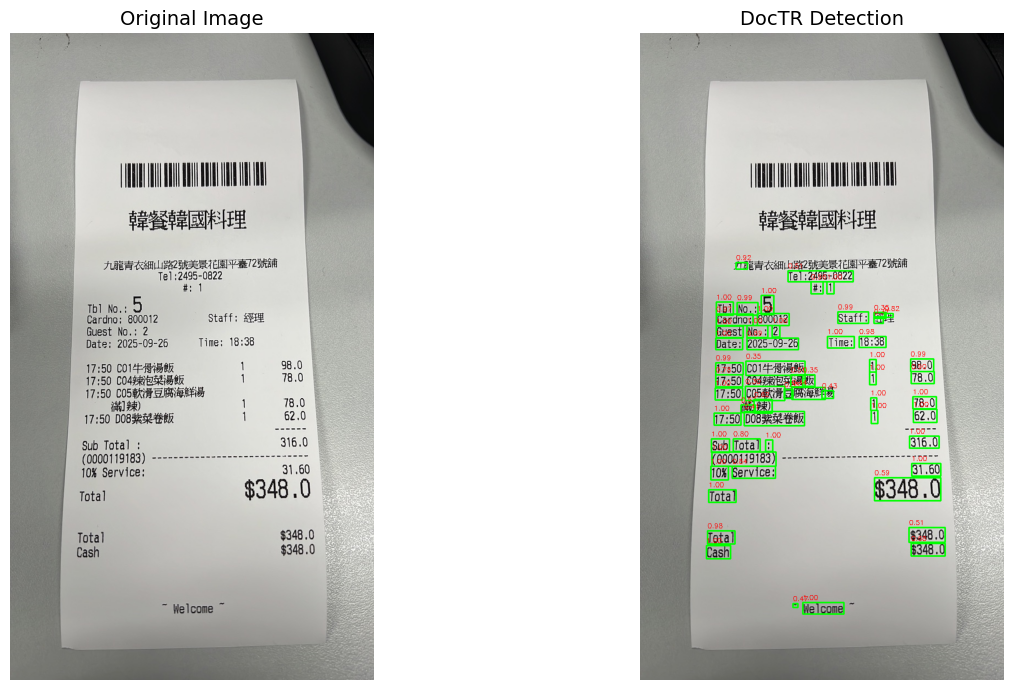


Extracted Full Text:
LE
Tel:2495-0822
#: 1
Tbl No.: 5
Cardno: 800012
Staff: &K ML B
Guest No.: 2
Date: 2025-09-26
Time: 18:38
17:50 C014717
1
98.0
17:50 CO4#ES  BR
1
78.0
17:50 CO5EA EZ JNEF 17
H NY ##)
1
78.0
17:50 DOSRER
1
62.0
Sub Total :
316.0
(0000119183)
10% Service:
31.60
Total
$348.0
Total
$348.0
Cash
$348.0
à Welcome


In [26]:
# DocTR (Document Text Recognition) - 專業文檔 OCR 解決方案
# 安裝: pip install python-doctr[torch]
# 或: pip install python-doctr[tf] (使用 TensorFlow)

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import matplotlib.pyplot as plt
import cv2
import numpy as np

def process_with_doctr(image_path):
    """使用 DocTR 進行文檔處理和 OCR"""
    
    # 初始化 OCR 模型 (使用預訓練模型)
    print("Loading DocTR model...")
    model = ocr_predictor(pretrained=True)
    
    # 讀取文檔
    print("Loading document...")
    doc = DocumentFile.from_images(image_path)
    
    # 執行 OCR
    print("Running OCR...")
    result = model(doc)
    
    # 讀取原圖用於顯示
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_with_boxes = image_rgb.copy()
    
    # 提取文字和座標
    print("\n" + "="*60)
    print("DocTR OCR Results:")
    print("="*60)
    
    all_text = []
    line_num = 1
    
    # 遍歷所有頁面、區塊、行和詞
    for page in result.pages:
        h, w = page.dimensions
        
        for block in page.blocks:
            for line in block.lines:
                line_text = []
                
                for word in line.words:
                    text = word.value
                    confidence = word.confidence
                    
                    # 獲取邊界框座標 (相對座標,需要轉換為像素)
                    bbox = word.geometry
                    x_min = int(bbox[0][0] * w)
                    y_min = int(bbox[0][1] * h)
                    x_max = int(bbox[1][0] * w)
                    y_max = int(bbox[1][1] * h)
                    
                    # 在圖上畫框
                    if confidence > 0.3:
                        cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                        cv2.putText(img_with_boxes, f"{confidence:.2f}", 
                                  (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 
                                  0.4, (255, 0, 0), 1)
                    
                    line_text.append(text)
                    print(f"  Word: '{text}' (confidence: {confidence:.3f})")
                
                # 合併一行的所有文字
                full_line = ' '.join(line_text)
                all_text.append(full_line)
                print(f"{line_num:2d}. {full_line}")
                line_num += 1
    
    # 顯示結果
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(img_with_boxes)
    axes[1].set_title('DocTR Detection', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return result, all_text

# 使用 DocTR
try:
    result, extracted_text = process_with_doctr('./samples/2.jpeg')
    
    print("\n" + "="*60)
    print("Extracted Full Text:")
    print("="*60)
    print('\n'.join(extracted_text))
    
except Exception as e:
    print(f"Error: {e}")
    print("\nNote: Make sure to install DocTR:")
    print("  pip install python-doctr[torch]")
    print("  or")
    print("  pip install python-doctr[tf]")

## 1. DocTR (Document Text Recognition)

**推薦指數:** ⭐⭐⭐⭐⭐

### 特點:
- ✅ 專業的文檔 OCR 庫
- ✅ 內建文檔偵測與佈局分析
- ✅ 使用深度學習預訓練模型
- ✅ 自動處理複雜文檔結構
- ✅ 支援多語言(包含繁體中文)

### 安裝:
```bash
pip install python-doctr[torch]
```

### 適用場景:
- 複雜的文檔結構
- 需要保留文檔佈局
- 高準確度要求

In [7]:
import easyocr
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['ch_tra', 'en'], gpu=True)
result = reader.readtext('./samples/2.jpeg', detail = 0)

print(result)

/Users/wing199901/GitHub/SHape/smart-spend-backend/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


['韓餐韓國料理', '九龍青衣細山路2號美景花園平壼72號舖', 'Te1;2495-0822', 'T1 Io', '5', 'Cardno', '800012', 'Staff', '經理', 'Guest Ilo.', 'Date: 2025-09-26', 'Time;', '18;38', '17;50 C01牛骨湯飯', '98.0', '17;50 C04辣泡菜湯飯', '18.0', '17;50', 'CO5軟滑豆腐海鮮湯', '滿]辣)', '78.0', '17;50 D08柴菜卷飯', '62.0', 'Sub Tota1', '315.0', '(0000119183)', '10% Service:', '31,60', 'Tota1', '$348.0', 'Tota1', '$348.0', 'Cash', '$348.0', 'Helcome']


## 2. EasyOCR - 基礎版

**推薦指數:** ⭐⭐⭐⭐

### 特點:
- ✅ 簡單易用,開箱即用
- ✅ 支援 80+ 種語言
- ✅ 可使用 GPU 加速
- ⚠️ Mac MPS 可能有警告訊息(可忽略)

### 使用方式:
- `detail=0`: 只返回文字
- `gpu=True`: 使用 GPU(Mac 上可能會有警告)

### 適用場景:
- 快速測試
- 簡單的文字提取
- 不需要座標資訊

In [8]:
import easyocr
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['ch_tra', 'en'], gpu=True)
result = reader.readtext('./samples/2.jpeg', detail = 1)

# result 格式: [([左上x, 左上y], [右下x, 右下y]), 文字, 信心度]
for bbox, text, confidence in result:
        print(f"文字: {text}, 信心度: {confidence:.2f}")

/Users/wing199901/GitHub/SHape/smart-spend-backend/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


文字: 韓餐韓國料理, 信心度: 0.99
文字: 九龍青衣細山路2號美景花園平壼72號舖, 信心度: 0.64
文字: Te1;2495-0822, 信心度: 0.81
文字: 5, 信心度: 1.00
文字: Cardno, 信心度: 1.00
文字: 800012, 信心度: 1.00
文字: Staff, 信心度: 0.96
文字: 經理, 信心度: 1.00
文字: Guest Ilo., 信心度: 0.65
文字: Date: 2025-09-26, 信心度: 0.61
文字: 18;38, 信心度: 0.50
文字: 17;50 C01牛骨湯飯, 信心度: 0.68
文字: 98.0, 信心度: 0.92
文字: 17;50 C04辣泡菜湯飯, 信心度: 0.93
文字: 18.0, 信心度: 0.71
文字: 17;50, 信心度: 0.99
文字: CO5軟滑豆腐海鮮湯, 信心度: 0.84
文字: 滿]辣), 信心度: 0.81
文字: 78.0, 信心度: 0.83
文字: 17;50 D08柴菜卷飯, 信心度: 0.86
文字: 62.0, 信心度: 0.82
文字: Sub Tota1, 信心度: 0.90
文字: 315.0, 信心度: 0.59
文字: (0000119183), 信心度: 0.98
文字: 10% Service:, 信心度: 0.62
文字: 31,60, 信心度: 0.66
文字: Tota1, 信心度: 0.54
文字: $348.0, 信心度: 0.80
文字: Tota1, 信心度: 0.81
文字: $348.0, 信心度: 0.99
文字: Cash, 信心度: 1.00
文字: $348.0, 信心度: 1.00
文字: Helcome, 信心度: 0.97


## 3. EasyOCR - 詳細版

**推薦指數:** ⭐⭐⭐⭐

### 特點:
- ✅ 返回文字座標(bounding box)
- ✅ 包含信心度分數
- ✅ 可過濾低信心度結果

### 使用方式:
- `detail=1`: 返回 `[座標, 文字, 信心度]`
- 可根據 `confidence` 過濾結果

### 適用場景:
- 需要文字位置資訊
- 後續要標記或裁切文字區域
- 需要評估辨識品質

In [13]:
# The cht chinese support of PaddleOCR is not good enough

from paddleocr import PaddleOCR

# 初始化(使用繁體中文模型)
ocr = PaddleOCR(use_textline_orientation=True, lang='chinese_cht')

result = ocr.predict('./samples/2.jpeg')

for res in result:
    res.print()
    res.save_to_img("output")
    res.save_to_json("output")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/wing199901/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/wing199901/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/wing199901/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/wing199901/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_server_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/Users/wing1999

## 4. PaddleOCR

**推薦指數:** ⭐⭐⭐

### 特點:
- ✅ 百度開源 OCR
- ✅ 對簡體中文支援極好
- ⚠️ 繁體中文支援一般
- ✅ 可儲存結果為圖片和 JSON

### 使用方式:
- `lang='chinese_cht'`: 使用繁體中文模型
- `use_textline_orientation=True`: 偵測文字方向

### 適用場景:
- 簡體中文文件
- 需要輸出標註圖片
- 中國大陸的文件格式

### 注意:
❌ 實測對台灣發票的繁體中文支援不佳

初始化 EasyOCR...

偵測文件邊緣...
⚠️ 未能偵測到文件邊緣,使用原始圖片

偵測文件邊緣...
⚠️ 未能偵測到文件邊緣,使用原始圖片


/var/folders/fp/zn84l44d58bbdlhq0sb0t6zw0000gn/T/ipykernel_34730/2972586713.py:182: UserWarning: Glyph 32302 (\N{CJK UNIFIED IDEOGRAPH-7E2E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fp/zn84l44d58bbdlhq0sb0t6zw0000gn/T/ipykernel_34730/2972586713.py:182: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fp/zn84l44d58bbdlhq0sb0t6zw0000gn/T/ipykernel_34730/2972586713.py:182: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fp/zn84l44d58bbdlhq0sb0t6zw0000gn/T/ipykernel_34730/2972586713.py:182: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fp/zn84l44d58bbdlhq0sb0t6zw0000gn/T/ipykernel_34730/2972586713.py:182: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fp

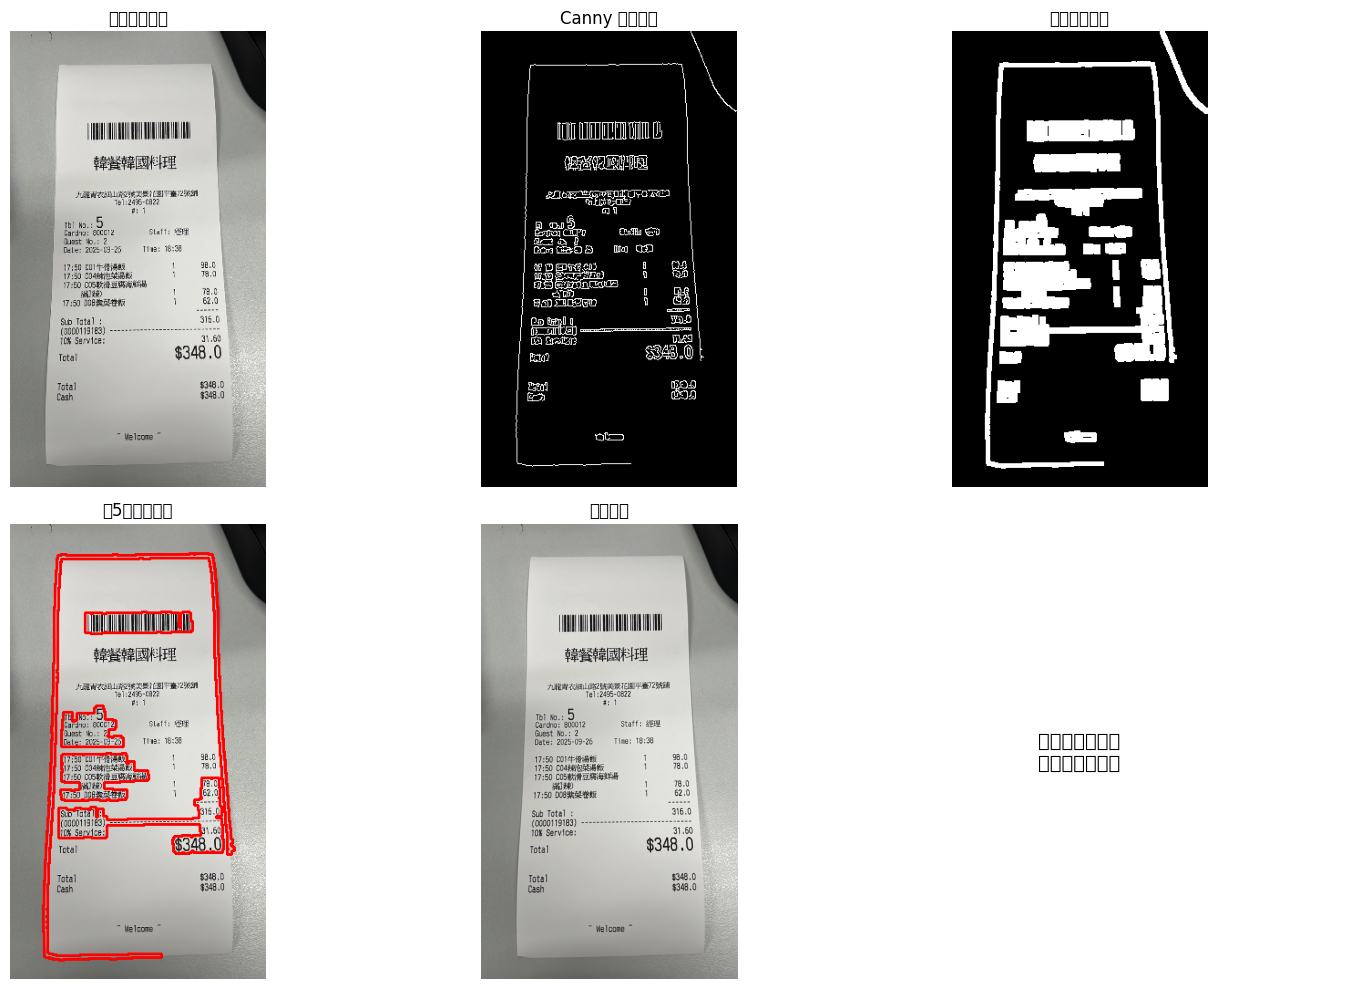


開始 OCR 辨識...


/Users/wing199901/GitHub/SHape/smart-spend-backend/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



辨識結果:
 1. [0.99] 韓餐韓國料理
 2. [0.63] 九龍青衣細山路2號美景花園平壼72號舖
 3. [0.81] Te1;2495-0822
 4. [0.42] T1 Io
 5. [1.00] 5
 6. [1.00] Cardno
 7. [1.00] 800012
 8. [0.96] Staff
 9. [1.00] 經理
10. [0.65] Guest Ilo.
11. [0.61] Date: 2025-09-26
12. [0.50] Time;
13. [0.50] 18;38
14. [0.68] 17;50 C01牛骨湯飯
15. [0.93] 98.0
16. [0.93] 17;50 C04辣泡菜湯飯
17. [0.71] 18.0
18. [0.99] 17;50
19. [0.84] CO5軟滑豆腐海鮮湯
20. [0.80] 滿]辣)
21. [0.83] 78.0
22. [0.86] 17;50 D08柴菜卷飯
23. [0.82] 62.0
24. [0.90] Sub Tota1
25. [0.60] 315.0
26. [0.98] (0000119183)
27. [0.62] 10% Service:
28. [0.66] 31,60
29. [0.54] Tota1
30. [0.80] $348.0
31. [0.81] Tota1
32. [0.99] $348.0
33. [1.00] Cash
34. [1.00] $348.0
35. [0.97] Helcome


In [22]:
# EazyOCR with Document Warping (改進版:多種策略偵測發票邊緣)

import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    """排序四個角點:左上、右上、右下、左下"""
    rect = np.zeros((4, 2), dtype="float32")
    
    # 左上角點的和最小,右下角點的和最大
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # 右上角點的差最小,左下角點的差最大
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    """四點透視變換"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # 計算新圖片的寬度
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # 計算新圖片的高度
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # 目標點
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # 計算透視變換矩陣並應用
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

def detect_document(image_path):
    """改進版:使用多種策略偵測文件邊緣"""
    # 讀取圖片
    image = cv2.imread(image_path)
    original = image.copy()
    ratio = image.shape[0] / 500.0
    resized = cv2.resize(image, (int(image.shape[1] / ratio), 500))
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # 策略1: 標準邊緣檢測
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    
    # 策略2: 形態學操作加強邊緣
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    
    # 策略3: 膨脹操作連接斷開的邊緣
    dilated = cv2.dilate(closed, kernel, iterations=1)
    
    # 尋找輪廓
    contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print("未找到任何輪廓")
        return original, None, None
    
    # 按面積排序輪廓
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    screenCnt = None
    image_area = resized.shape[0] * resized.shape[1]
    
    # 嘗試找出四邊形輪廓
    for i, c in enumerate(contours[:10]):  # 檢查前10個最大輪廓
        area = cv2.contourArea(c)
        
        # 過濾太小的輪廓(小於圖片面積的10%)
        if area < image_area * 0.1:
            continue
            
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # 找到四邊形
        if len(approx) == 4:
            screenCnt = approx
            print(f"找到四邊形! 輪廓 #{i}, 面積: {area:.0f}, 佔比: {area/image_area*100:.1f}%")
            break
        
        # 如果沒有找到完美的四邊形,嘗試5-8邊形
        if len(approx) >= 5 and len(approx) <= 8 and screenCnt is None:
            # 找出最外圍的4個點
            hull = cv2.convexHull(approx)
            if len(hull) >= 4:
                # 使用 Douglas-Peucker 算法簡化為4個點
                peri = cv2.arcLength(hull, True)
                simplified = cv2.approxPolyDP(hull, 0.03 * peri, True)
                if len(simplified) == 4:
                    screenCnt = simplified
                    print(f"簡化多邊形為四邊形! 輪廓 #{i}")
                    break
    
    # 顯示處理過程
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    axes[0, 0].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('縮小後的圖片')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(edged, cmap='gray')
    axes[0, 1].set_title('Canny 邊緣檢測')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(dilated, cmap='gray')
    axes[0, 2].set_title('形態學處理後')
    axes[0, 2].axis('off')
    
    if screenCnt is not None:
        # 在縮小的圖上畫出偵測到的四邊形
        contour_img = resized.copy()
        cv2.drawContours(contour_img, [screenCnt], -1, (0, 255, 0), 3)
        
        # 縮放回原始尺寸
        screenCnt_scaled = screenCnt.reshape(4, 2) * ratio
        
        # 透視變換
        warped = four_point_transform(original, screenCnt_scaled)
        warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
        
        # 在原圖上畫輪廓
        original_with_contour = original.copy()
        cv2.drawContours(original_with_contour, [screenCnt_scaled.astype(int)], -1, (0, 255, 0), 5)
        
        axes[1, 0].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('偵測到的邊緣(縮小版)')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(cv2.cvtColor(original_with_contour, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('原圖上的邊緣')
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(warped_rgb)
        axes[1, 2].set_title('矯正後的圖片')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return warped, screenCnt_scaled, warped_rgb
    else:
        print("⚠️ 未能偵測到文件邊緣,使用原始圖片")
        
        # 顯示所有找到的輪廓
        all_contours_img = resized.copy()
        cv2.drawContours(all_contours_img, contours[:5], -1, (0, 0, 255), 2)
        
        axes[1, 0].imshow(cv2.cvtColor(all_contours_img, cv2.COLOR_BGR2RGB))
        axes[1, 0].set_title('前5個最大輪廓')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[1, 1].set_title('原始圖片')
        axes[1, 1].axis('off')
        
        axes[1, 2].text(0.5, 0.5, '未偵測到四邊形\n將使用原始圖片', 
                       ha='center', va='center', fontsize=14)
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return original, None, None

# 使用文件矯正
print("初始化 EasyOCR...")
reader = easyocr.Reader(['ch_tra', 'en'], gpu=True)

print("\n偵測文件邊緣...")
processed_img, contour, warped_rgb = detect_document('./samples/2.jpeg')

print("\n開始 OCR 辨識...")
result = reader.readtext(processed_img, detail=1)

print("\n" + "="*50)
print("辨識結果:")
print("="*50)
for i, (bbox, text, confidence) in enumerate(result, 1):
    if confidence > 0.4:  # 降低閾值以顯示更多結果
        print(f"{i:2d}. [{confidence:.2f}] {text}")

## 5. OpenCV 自動裁切與透視變換

**推薦指數:** ⭐⭐⭐

### 特點:
- ✅ 自動偵測文件邊緣
- ✅ 透視變換矯正扭曲
- ✅ 移除背景,只保留文件
- ⚠️ 需要清晰的邊緣
- ⚠️ 複雜背景可能失敗

### 處理流程:
1. 縮小圖片加快處理
2. Canny 邊緣檢測
3. 形態學操作強化邊緣
4. 尋找四邊形輪廓
5. 透視變換矯正

### 適用場景:
- 發票有明顯邊緣
- 背景單純
- 需要移除背景雜訊

### 顯示內容:
- 6 張圖展示完整處理流程
- 顯示偵測到的輪廓資訊

## 方案比較:發票圖片裁切與矯正

### 方案 1: DocTR (Document Text Recognition)
- ✅ 專門用於文件掃描和 OCR
- ✅ 內建文件偵測和矯正
- ✅ 支援多種文件類型

### 方案 2: deskew
- ✅ 簡單易用的文件去傾斜工具
- ✅ 自動偵測並矯正文件角度
- ⚠️ 不做裁切,只做旋轉矯正

### 方案 3: OpenCV 手動處理 (目前使用)
- ⚠️ 需要調參數
- ⚠️ 對複雜背景效果不佳
- ✅ 不需額外安裝

### 方案 4: 手動裁切 + OCR
- ✅ 最簡單
- ✅ 適合固定角度拍攝
- ⚠️ 需要用戶手動選擇區域

[2025-10-09 02:55:47,420] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.


Detected skew angle: -1.00 degrees
Image deskewed!


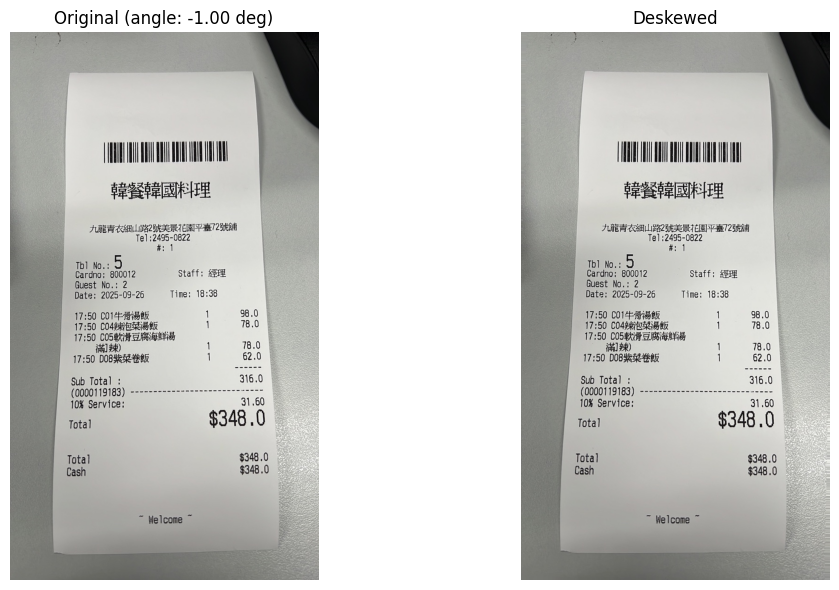


OCR Results:
 1. [0.83] 韓餐韓國料理
 3. [0.75] Te1:2495-0822
 5. [1.00] 5
 6. [0.46] Cardno; 8ooo12
 7. [1.00] Staff
 8. [0.99] 經理
 9. [0.63] Guest Io.
10. [1.00] 2
11. [0.64] Date: 2025-09-26
12. [0.92] Time: 18;38
13. [0.75] 17;50 C01牛骨湯飯
14. [1.00] 98.0
15. [0.84] 17;50 C04辣泡菜湯飯
16. [0.87] 78.0
17. [0.93] 17;50 C05軟滑豆腐海鮮湯
18. [0.95] 滿]辣)
19. [0.82] 78.0
20. [0.87] 17;50 D08柴菜卷飯
21. [0.70] 62.0
22. [0.76] Sub Total
23. [0.94] 316.0
24. [0.98] (0000119183)
25. [0.62] 10* Service:
26. [0.89] 31.60
27. [0.50] Total
28. [0.82] $348.0
29. [0.85] Tota1
30. [0.95] $348.0
31. [1.00] Cash
32. [1.00] $348.0
33. [0.97] Helcome


In [24]:
# 方案 1: 使用 deskew 自動矯正文件傾斜 (最簡單有效)
# pip install deskew

import easyocr
import cv2
import numpy as np
from PIL import Image
from deskew import determine_skew
import matplotlib.pyplot as plt

def rotate_image(image, angle):
    """旋轉圖片"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def auto_deskew(image_path):
    """自動去傾斜"""
    # 讀取圖片
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 偵測傾斜角度
    angle = determine_skew(gray)
    print(f"Detected skew angle: {angle:.2f} degrees")
    
    # 矯正傾斜
    if abs(angle) > 0.5:  # 只有角度大於0.5度才矯正
        rotated = rotate_image(image, angle)
        print("Image deskewed!")
    else:
        rotated = image
        print("Image is already straight")
    
    return rotated, angle

# 使用 deskew
reader = easyocr.Reader(['ch_tra', 'en'], gpu=False)
deskewed_img, angle = auto_deskew('./samples/2.jpeg')

# 顯示矯正前後
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
original = cv2.imread('./samples/2.jpeg')
axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original (angle: {angle:.2f} deg)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(deskewed_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Deskewed', fontsize=12)
axes[1].axis('off')
plt.tight_layout()
plt.show()

# OCR
result = reader.readtext(deskewed_img, detail=1)

print("\n" + "="*50)
print("OCR Results:")
print("="*50)
for i, (bbox, text, confidence) in enumerate(result, 1):
    if confidence > 0.4:
        print(f"{i:2d}. [{confidence:.2f}] {text}")

## 6. Deskew - 自動矯正傾斜

**推薦指數:** ⭐⭐⭐⭐⭐

### 特點:
- ✅ 超級簡單,只需幾行代碼
- ✅ 自動偵測傾斜角度
- ✅ 自動旋轉矯正
- ✅ 適合固定角度拍攝
- ⚠️ 只做旋轉,不做裁切

### 安裝:
```bash
pip install deskew
```

### 處理流程:
1. 偵測圖片傾斜角度
2. 如果角度 > 0.5°,自動矯正
3. 返回矯正後的圖片

### 適用場景:
- 文件有輕微傾斜
- 不需要裁切背景
- 想要最簡單的解決方案

### 優點:
✨ **最推薦用於傾斜矯正** - 簡單有效!

[2025-10-09 03:00:17,866] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.


Step 1: Edge Detection
Could not find document outline. Using original image.


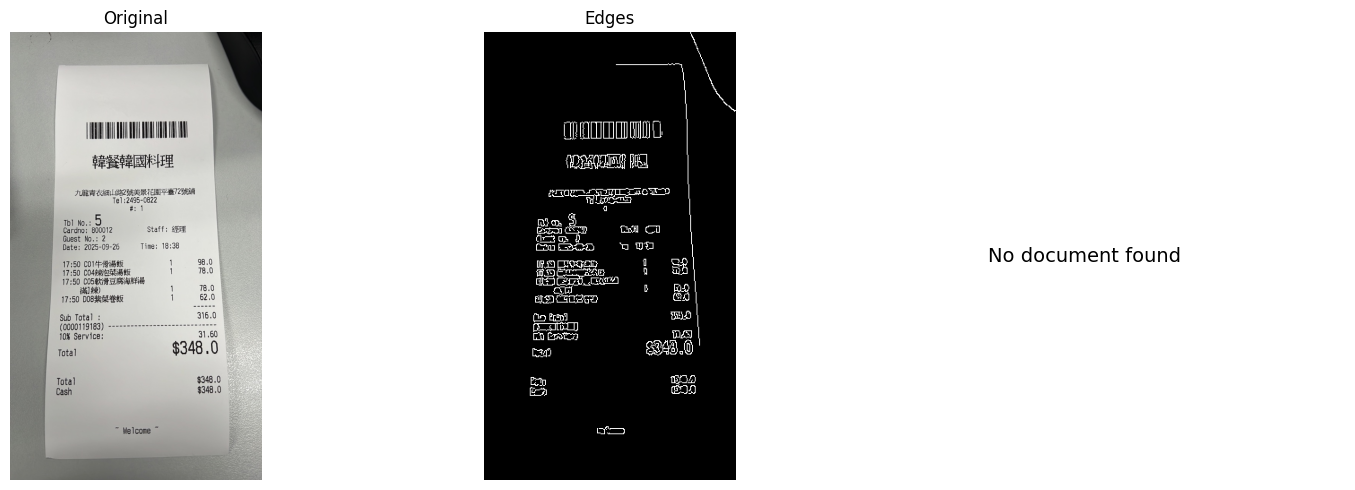


OCR Results:
 1. [0.99] 韓餐韓國料理
 2. [0.63] 九龍青衣細山路2號美景花園平壼72號舖
 3. [0.81] Te1;2495-0822
 4. [0.42] T1 Io
 5. [1.00] 5
 6. [1.00] Cardno
 7. [1.00] 800012
 8. [0.96] Staff
 9. [1.00] 經理
10. [0.65] Guest Ilo.
11. [0.61] Date: 2025-09-26
12. [0.50] Time;
13. [0.50] 18;38
14. [0.68] 17;50 C01牛骨湯飯
15. [0.93] 98.0
16. [0.93] 17;50 C04辣泡菜湯飯
17. [0.71] 18.0
18. [0.99] 17;50
19. [0.84] CO5軟滑豆腐海鮮湯
20. [0.80] 滿]辣)
21. [0.83] 78.0
22. [0.86] 17;50 D08柴菜卷飯
23. [0.82] 62.0
24. [0.90] Sub Tota1
25. [0.60] 315.0
26. [0.98] (0000119183)
27. [0.62] 10% Service:
28. [0.66] 31,60
29. [0.54] Tota1
30. [0.80] $348.0
31. [0.81] Tota1
32. [0.99] $348.0
33. [1.00] Cash
34. [1.00] $348.0
35. [0.97] Helcome


In [25]:
# 方案 2: 使用 imutils 的自動裁切 (專門為掃描文件設計)
# pip install imutils

import easyocr
import cv2
import numpy as np
import imutils
from imutils.perspective import four_point_transform
from skimage.filters import threshold_local
import matplotlib.pyplot as plt

def scan_document(image_path):
    """模擬文件掃描儀效果"""
    # 讀取圖片
    image = cv2.imread(image_path)
    orig = image.copy()
    
    # 計算縮放比例
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height=500)
    
    # 轉灰階、高斯模糊、邊緣檢測
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    
    print("Step 1: Edge Detection")
    
    # 尋找輪廓
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    
    screenCnt = None
    
    # 找四邊形
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if len(approx) == 4:
            screenCnt = approx
            break
    
    # 顯示結果
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    if screenCnt is None:
        print("Could not find document outline. Using original image.")
        axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original', fontsize=12)
        axes[0].axis('off')
        
        axes[1].imshow(edged, cmap='gray')
        axes[1].set_title('Edges', fontsize=12)
        axes[1].axis('off')
        
        axes[2].text(0.5, 0.5, 'No document found', ha='center', va='center', fontsize=14)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return orig
    
    print("Step 2: Found document contour")
    
    # 在原圖上應用透視變換
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
    
    # 可選:轉灰階並二值化(類似掃描效果)
    # warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    # T = threshold_local(warped, 11, offset=10, method="gaussian")
    # warped = (warped > T).astype("uint8") * 255
    
    # 顯示
    outline = image.copy()
    cv2.drawContours(outline, [screenCnt], -1, (0, 255, 0), 2)
    
    axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(outline, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Outline Detected', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Scanned', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return warped

# 使用文件掃描
reader = easyocr.Reader(['ch_tra', 'en'], gpu=False)
scanned = scan_document('./samples/2.jpeg')

# OCR
result = reader.readtext(scanned, detail=1)

print("\n" + "="*50)
print("OCR Results:")
print("="*50)
for i, (bbox, text, confidence) in enumerate(result, 1):
    if confidence > 0.4:
        print(f"{i:2d}. [{confidence:.2f}] {text}")

## 7. Imutils 文件掃描

**推薦指數:** ⭐⭐⭐⭐

### 特點:
- ✅ 專門為文件掃描設計
- ✅ 使用 `four_point_transform` 透視變換
- ✅ 可選擇性套用掃描效果(灰階+二值化)
- ✅ 比純 OpenCV 更穩定

### 安裝:
```bash
pip install imutils scikit-image
```

### 處理流程:
1. 圖片縮小加快處理
2. 邊緣檢測
3. 尋找最大的四邊形輪廓
4. 使用 `four_point_transform` 矯正
5. 可選:套用掃描效果

### 適用場景:
- 需要完整的掃描儀效果
- 文件有清晰邊緣
- 想要黑白掃描效果

### 顯示內容:
- 原圖
- 偵測到的輪廓
- 矯正後的文件

[2025-10-09 02:54:25,732] [ WARNING] easyocr.py:71 - Using CPU. Note: This module is much faster with a GPU.
/Users/wing199901/GitHub/SHape/smart-spend-backend/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


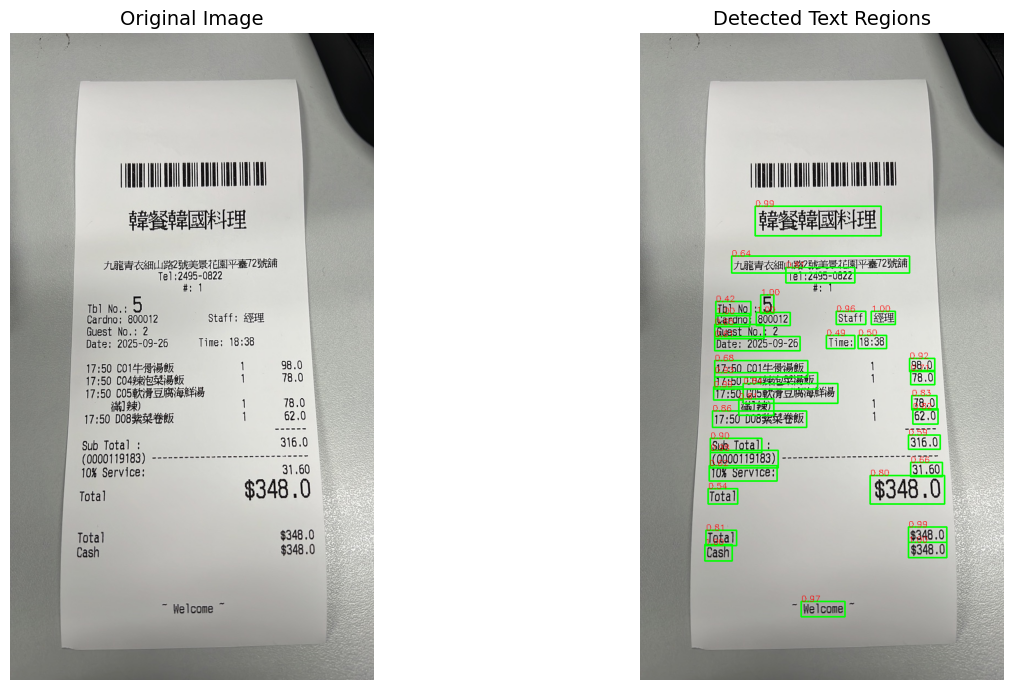


OCR Results (No Preprocessing):
 1. [0.99] 韓餐韓國料理
 2. [0.64] 九龍青衣細山路2號美景花園平壼72號舖
 3. [0.81] Te1;2495-0822
 4. [0.42] T1 Io
 5. [1.00] 5
 6. [1.00] Cardno
 7. [1.00] 800012
 8. [0.96] Staff
 9. [1.00] 經理
10. [0.65] Guest Ilo.
11. [0.61] Date: 2025-09-26
12. [0.49] Time;
13. [0.50] 18;38
14. [0.68] 17;50 C01牛骨湯飯
15. [0.92] 98.0
16. [0.93] 17;50 C04辣泡菜湯飯
17. [0.71] 18.0
18. [0.99] 17;50
19. [0.84] CO5軟滑豆腐海鮮湯
20. [0.81] 滿]辣)
21. [0.83] 78.0
22. [0.86] 17;50 D08柴菜卷飯
23. [0.82] 62.0
24. [0.90] Sub Tota1
25. [0.59] 315.0
26. [0.98] (0000119183)
27. [0.62] 10% Service:
28. [0.66] 31,60
29. [0.54] Tota1
30. [0.80] $348.0
31. [0.81] Tota1
32. [0.99] $348.0
33. [1.00] Cash
34. [1.00] $348.0
35. [0.97] Helcome


In [23]:
# 方案 3: 最簡單 - 直接用 EasyOCR 不做任何預處理
# EasyOCR 本身已經很強大,很多時候不需要預處理

import easyocr
import cv2
import matplotlib.pyplot as plt

# 直接 OCR,不做任何預處理
reader = easyocr.Reader(['ch_tra', 'en'], gpu=False)

# 讀取原圖
image = cv2.imread('./samples/2.jpeg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# OCR with visualization
result = reader.readtext('./samples/2.jpeg', detail=1)

# 在圖上畫出偵測到的文字區域
img_with_boxes = image_rgb.copy()
for bbox, text, confidence in result:
    if confidence > 0.4:
        # 轉換座標
        points = np.array(bbox, dtype=np.int32)
        cv2.polylines(img_with_boxes, [points], True, (0, 255, 0), 2)
        
        # 在左上角標註文字(避免中文顯示問題,只顯示信心度)
        cv2.putText(img_with_boxes, f"{confidence:.2f}", 
                   tuple(points[0]), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (255, 0, 0), 1)

# 顯示
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(image_rgb)
axes[0].set_title('Original Image', fontsize=14)
axes[0].axis('off')

axes[1].imshow(img_with_boxes)
axes[1].set_title('Detected Text Regions', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 輸出結果
print("\n" + "="*60)
print("OCR Results (No Preprocessing):")
print("="*60)
for i, (bbox, text, confidence) in enumerate(result, 1):
    if confidence > 0.4:
        print(f"{i:2d}. [{confidence:.2f}] {text}")

---

## 📋 總結與建議

### 🎯 推薦使用流程 (按順序):

#### 第一步:快速測試
1. **方案 1 (EasyOCR 基礎版)** - 最快速的測試
2. **方案 3 (EasyOCR + 視覺化)** - 檢查文字偵測效果

#### 第二步:如果效果不佳,加入預處理
3. **方案 4 (Deskew)** - 圖片有傾斜時使用
4. **方案 5 (Imutils)** - 需要裁切背景時使用
5. **方案 6 (OpenCV)** - 複雜情況的自動裁切

#### 第三步:追求更高準確度
6. **方案 7 (DocTR)** - 專業文檔 OCR,準確度最高

### 📊 各方案特點總結:

| 方案 | 難度 | 速度 | 準確度 | 適用場景 |
|------|------|------|--------|---------|
| **EasyOCR 基礎** | ⭐ | ⚡⚡⚡ | ⭐⭐⭐⭐ | 快速測試 |
| **EasyOCR 詳細** | ⭐ | ⚡⚡⚡ | ⭐⭐⭐⭐ | 需要座標資訊 |
| **EasyOCR 視覺化** | ⭐ | ⚡⚡⚡ | ⭐⭐⭐⭐ | 檢查偵測效果 |
| **Deskew** | ⭐⭐ | ⚡⚡ | ⭐⭐⭐⭐ | 圖片傾斜 |
| **Imutils** | ⭐⭐⭐ | ⚡⚡ | ⭐⭐⭐⭐ | 需要裁切背景 |
| **OpenCV** | ⭐⭐⭐⭐ | ⚡⚡ | ⭐⭐⭐ | 複雜背景處理 |
| **DocTR** | ⭐⭐ | ⚡ | ⭐⭐⭐⭐⭐ | 高準確度需求 |
| **PaddleOCR** | ⭐⭐ | ⚡⚡ | ⭐⭐ | 簡體中文 |

### 💡 實務建議:

**情境 1: 圖片品質好**
- 直接用 **方案 1 或 3** (EasyOCR)

**情境 2: 圖片傾斜**
- **方案 4 (Deskew)** → **方案 3 (視覺化)**

**情境 3: 背景複雜**
- **方案 5 (Imutils)** 或 **方案 6 (OpenCV)** → **方案 2 (EasyOCR)**

**情境 4: 需要最高準確度**
- 直接用 **方案 7 (DocTR)**

**情境 5: 簡體中文文件**
- 用 **方案 8 (PaddleOCR)**

### 🔧 效能優化技巧:

1. **GPU 設定**
   - Mac: 使用 `gpu=False` 避免 MPS 警告
   - Windows/Linux with NVIDIA: 使用 `gpu=True` 加速

2. **信心度閾值**
   - 預設: `0.5`
   - 寬鬆: `0.3-0.4` (查看更多結果)
   - 嚴格: `0.6-0.7` (只保留高信心度結果)

3. **批次處理**
   - 重用 `reader` 物件,避免重複載入模型
   - 大圖片先縮小測試,確認效果後再處理原圖

4. **記憶體管理**
   - 處理完畢後刪除大型圖片變數
   - 使用 `del` 和 `gc.collect()` 釋放記憶體

### ⚠️ 注意事項:

- **PaddleOCR** 對台灣繁體中文支援不佳,不推薦用於台灣發票
- **OpenCV 方案** 需要清晰的文件邊緣,複雜背景可能失敗
- **DocTR** 準確度高但速度較慢,適合對準確度要求高的場景

## 8. EasyOCR + 視覺化

**推薦指數:** ⭐⭐⭐⭐⭐

### 特點:
- ✅ 最簡單的方案
- ✅ 直接使用 EasyOCR,不做預處理
- ✅ 視覺化顯示偵測到的文字區域
- ✅ 標記信心度分數
- ✅ 很多情況不需要預處理!

### 使用方式:
- 直接對原圖進行 OCR
- 在圖上畫出偵測到的文字框
- 顯示每個文字的信心度

### 與方案 2、3 的差異:
- **方案 2**: 只輸出文字列表
- **方案 3**: 輸出文字 + 座標 + 信心度
- **方案 8**: 在圖片上視覺化標記所有文字區域

### 適用場景:
- 圖片品質良好
- 光線充足,文字清晰
- 背景相對簡單
- 需要視覺化檢查 OCR 結果

### 顯示內容:
- 原圖
- 標記文字區域和信心度的圖

### 建議:
💡 **先試這個方案!** 很多時候不需要複雜的預處理就能得到好結果。如果效果不佳,再考慮其他方案。